# Project 2 - Deep Learning (LSTM) Model Stock Predictor
## Objective
Stock investiment is probably one of the hardest investment to master because of the unpredictable natural of stock market. Experts have studied the market and derived several technical analysis for predicting stuck market. Unfortunately, most of the technical analysis are quite complex and not many people know how to use them. Even people with good understanding of the technical analysis would need to spend a considerable amount of time analyzing the data before reaching a reasonable confident conclusion. 
The objective of this project is to train a regression model based on the available historical stuck price. Once the model is trained, the user should be able to provide the current stock price and get the prediction of the price for the next 30 days using the model.

## Goals
From Project 1 - Regression Model Stock Predictor, it shows that both SVR and DecisionTreeRegressor can predict the trend of the stock price and DecisionTreeRegressor shows that it performs better than SVR.

The goal of this project is to use the same stock price data to train a deep learning model (LSTM) to see how it compares to the models from project 1


## Project Outline
The project has 3 steps:
1. Explore and analyze the dataset
2. Modify and prepare the dataset for training
3. Evaluate the performance of the model


## 1. Explore and analyze the dataset
Download the dataset from Quandl if it is not available in local disk. 
Note: For this project, AAPL stock price is used since it is one of the few stock price that Quandl provide for free 

In [1]:
import os
import quandl
import pandas as pd
quandl.ApiConfig.api_key = "nVD4QZoCjEQijoM1Pvzz"
# download data from quandl and save it in a csv file if the file does not exist
if not os.path.exists('data/AAPL.csv'):
    data = quandl.get_table("WIKI/PRICES", qopts={'columns': ['ticker', 'date', 'adj_close', 'adj_volume']}, 
                            ticker=AAPL, paginate=True)
    if data.shape[0] > 1:
        data.to_csv('data/AAPL.csv', '\t')
# read the data from csv file
df = pd.read_csv('data/AAPL.csv', usecols=['date', 'adj_close'], delimiter='\t', header=0,
                 index_col='date', parse_dates=True)
df.head()

,adj_close
date,
2018-03-27,168.340
2018-03-26,172.770
2018-03-23,164.940
2018-03-22,168.845
2018-03-21,171.270


In [2]:
# check dataset's shape and info to see if cleaning is required
df.shape

(9400, 1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9400 entries, 2018-03-27 to 1980-12-12
Data columns (total 1 columns):
adj_close    9400 non-null float64
dtypes: float64(1)
memory usage: 146.9 KB


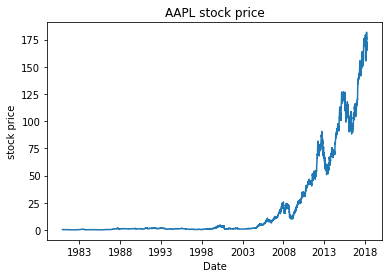

In [4]:
# above info shows that there is no null value and the dataset is clean
# The line plot of the dataset is created which shows the tread of the dataset
import matplotlib.pyplot as plt
df.sort_index(inplace=True)
plt.plot(df)
plt.title('AAPL stock price')
plt.xlabel('Date')
plt.ylabel('stock price')
plt.show()

In [5]:
df.describe()

,adj_close
count,9400.000000
mean,21.567664
std,39.271266
min,0.161731
25%,0.922730
50%,1.437445
75%,20.294924
max,181.720000


## 2. Modify and prepare the dataset for training

As shown in the plot above, the data has an increasing trend. To make a better prediction, we can remove the tread by differencing

In [6]:
from pandas import Series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

raw_values = df.values
diff_series = difference(raw_values, 1)
diff_values = diff_series.values
diff_values = diff_values.reshape(len(diff_values), 1)
print(diff_values[:5])
print(diff_values[-5:])

[[array([-0.02205422])]
 [array([-0.02940563])]
 [array([0.00911574])]
 [array([0.01117414])]
 [array([0.02381856])]]
[[array([-3.97])]
 [array([-2.425])]
 [array([-3.905])]
 [array([7.83])]
 [array([-4.43])]]


As shown in the output above, the diff_values still has a large range. This can degrade the predictive performance of many machine learning algorighms. Unscaled data can also slow down or even prevent the convergence of many gradient-based estimators. 
Many estimators are designed with the assumption that each feature takes values close to zero. 
There are many differenct scalers. For this project, MinMaxScaler that rescale values to -1, 1 is used

In [7]:
from sklearn.preprocessing import MinMaxScaler
# rescale values to -1, 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(diff_values)
scaled_values = scaled_values.reshape(len(scaled_values), 1)
print(scaled_values[:5])
print(scaled_values[-5:])

[[0.02246711]
 [0.02155191]
 [0.02634758]
 [0.02660384]
 [0.02817799]]
[[-0.46902807]
 [-0.27668499]
 [-0.46093597]
 [ 1.        ]
 [-0.52629527]]


/Users/allenliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


The stock prediction is a multi-step forecast problem. For a given time step, the model is required to make the next 30 day prediction. That is given t-1, forecast t, t+1, t+2... t+30. 
A key function to help transform time series data into multi-step forecast problem is the shift() function. 
By shifting the input (X) by -1 for 30 times, we can mimic the 30 days forecast.

i.e. 

```X    y1  y2  y3  .... y30
t    t+1 t+2 t+3 .... t+30```


In [8]:
from pandas import DataFrame
from pandas import concat

# convert time series into multi-step problem
def series_to_supervised(data, n_in, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

supervised = series_to_supervised(scaled_values, 1, 30)
supervised_values = supervised.values
print(supervised_values.shape)
print(supervised_values)

(9369, 31)
[[ 0.02246711  0.02155191  0.02634758 ...  0.02429752  0.02475512
   0.02338232]
 [ 0.02155191  0.02634758  0.02660384 ...  0.02475512  0.02338232
   0.02314436]
 [ 0.02634758  0.02660384  0.02817799 ...  0.02338232  0.02314436
   0.02224746]
 ...
 [-0.50015155  0.10613377  0.86430164 ... -0.46902807 -0.27668499
  -0.46093597]
 [ 0.10613377  0.86430164  0.22813779 ... -0.27668499 -0.46093597
   1.        ]
 [ 0.86430164  0.22813779  0.40242926 ... -0.46093597  1.
  -0.52629527]]


Next, we can split the data into training and test sets. Set  n_test = 3700

In [9]:
n_test = 3700 
train, test = supervised_values[0:-n_test], supervised_values[-n_test:]

In [10]:
#reshape training into X,y
X, y = train[:, 0:1], train[:, 1:]
print(X[0])
print(y[0])

[0.02246711]
[0.02155191 0.02634758 0.02660384 0.02817799 0.02773869 0.02750074
 0.02817799 0.03070396 0.02612793 0.02360197 0.02340062 0.02588998
 0.02383992 0.02246711 0.02270506 0.02405957 0.0281963  0.02473682
 0.02316267 0.02545068 0.02634758 0.02475512 0.0286356  0.02340062
 0.02634758 0.02588998 0.02499308 0.02429752 0.02475512 0.02338232]


## 3. Evaluate the performance of the model 

Next, we need to fit an LSTM network model to the training data. This first requires that the training dataset be transformed from a 2D array [samples, features] to a 3D array [samples, timesteps, features]. We will fix time steps at 1, so this change is straightforward.

Next, we will use a simple structure with 1 hidden layer with 1 LSTM unit, then an output layer with linear activation and 30 output values. The network will use a mean squared error loss function and the efficient ADAM optimization algorithm.

The LSTM is stateful; this means that we have to manually reset the state of the network at the end of each training epoch.

The same batch size must be used for training and prediction, and we require predictions to be made at each time step of the test dataset. This means that a batch size of 1 must be used. 


In [11]:
# fit an LSTM network to training data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

n_batch = 1
nb_epoch = 5
n_neurons = 1
def fit_lstm(train, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:1], train[:, 1:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

model = fit_lstm(train, n_batch, nb_epoch, n_neurons)

/Users/allenliu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Using the trained model, we can make prediction using the test data

In [12]:

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]


# evaluate the persistence model
def make_forecasts(model, n_batch, test):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:1], test[i, 1:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts



forecasts = make_forecasts(model, 1, test)
print(forecasts[0])

[0.026198275, 0.026595317, 0.026284806, 0.026084756, 0.025470339, 0.026116805, 0.025319705, 0.0253685, 0.02522781, 0.025257384, 0.025462227, 0.024972916, 0.025548225, 0.025344457, 0.02511889, 0.025582576, 0.02502049, 0.025551403, 0.025287965, 0.025724124, 0.024695963, 0.02569609, 0.025325477, 0.025377678, 0.025558801, 0.025288867, 0.025995502, 0.025619216, 0.025489422, 0.025804572]


After the forecasts have been made, we need to invert the transforms to return the values back into the original scale. This is needed so that we can calculate error scores and plots that are comparable with the actual test output.

In [13]:
from numpy import array

def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i - 1])
    return inverted

forecasts = inverse_transform(df, forecasts, scaler, n_test + 2)
print(forecasts[0])

[array([1.26606789]), array([1.27717357]), array([1.28578507]), array([1.29278967]), array([1.29485894]), array([1.30212097]), array([1.30298027]), array([1.30423152]), array([1.30435267]), array([1.30471138]), array([1.3067155]), array([1.30478921]), array([1.3074841]), array([1.30854223]), array([1.30778848]), array([1.3107593]), array([1.30921515]), array([1.31193557]), array([1.31253992]), array([1.31664773]), array([1.31249681]), array([1.31637943]), array([1.3172851]), array([1.31861007]), array([1.32138992]), array([1.32200151]), array([1.32828917]), array([1.3315543]), array([1.33377686]), array([1.33853086])]


Get the actual test target and transform the data to their original scale

In [14]:
actual = [row[1:] for row in test]
actual = inverse_transform(df, actual, scaler, n_test + 2)

Evaluate the RMSE for each forecast time step

In [15]:
from math import sqrt
from sklearn.metrics import mean_squared_error

def evaluate_forecasts(test, forecasts, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i + 1), rmse))

evaluate_forecasts(actual, forecasts, 30)

t+1 RMSE: 1.029829
t+2 RMSE: 1.477894
t+3 RMSE: 1.801997
t+4 RMSE: 2.076532
t+5 RMSE: 2.337016
t+6 RMSE: 2.561369
t+7 RMSE: 2.762461
t+8 RMSE: 2.968359
t+9 RMSE: 3.154767
t+10 RMSE: 3.338550
t+11 RMSE: 3.514315
t+12 RMSE: 3.670143
t+13 RMSE: 3.812502
t+14 RMSE: 3.957678
t+15 RMSE: 4.108001
t+16 RMSE: 4.242883
t+17 RMSE: 4.374699
t+18 RMSE: 4.512716
t+19 RMSE: 4.649280
t+20 RMSE: 4.779813
t+21 RMSE: 4.914060
t+22 RMSE: 5.044749
t+23 RMSE: 5.159904
t+24 RMSE: 5.269012
t+25 RMSE: 5.380156
t+26 RMSE: 5.480569
t+27 RMSE: 5.583952
t+28 RMSE: 5.684307
t+29 RMSE: 5.782388
t+30 RMSE: 5.879272


Plot the forecast aginst the original dataset

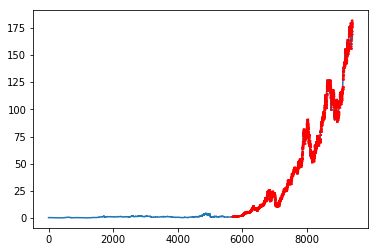

In [16]:
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    plt.show()

plot_forecasts(df, forecasts, n_test + 2)

### Conclusion:

As shown in the RMSE values and the graph above, LSTM appears to be the best model for predicting the stock price compare with the other two models (SVR and DecisionTreeRegressor) from Capstone Project 1. 

Nevertheless, there is still room for improvement for the LSTM model. Following are ways that might improve it's performance:
1. Tune the LSTM: Grid search some of the LSTM parameters used in the tutorial, such as number of epochs, number of neurons, and number of layers to see if you can further lift performance.
2. Dropout: Slow down learning with regularization methods like dropout on the recurrent LSTM connections.
3. Regularization: Explore how weight regularization, such as L1 and L2, can be used to slow down learning and overfitting of the network on some configurations.